### Workflow:

1. Set initial variables and load 1 dataset for the stoichiometry
2. Select initial hyperparameters and train, select best model.
3. Load other data for same stoichiometry, transfer model and train
4. Select best model for each velocity
5. Extract data and build linear graphic

### Example.
I will illustrate this workflow for La0.9Ca0.1NO3

In [1]:
#Hide warnings when logging
from tensorflow.compat.v1.logging import set_verbosity,ERROR
set_verbosity(ERROR)

from Utils import *

Using TensorFlow backend.


## 1. Create variables and load dataset

In [2]:
directory = 'models/La0.9/'  #This directory should be created by now. If not, go do it!
stoichiom = 'La0.9'          #Which stoichiometry is to be used in this example?
name='data/La0.9Ca0.1NiO310C.txt'  #First data set to load.

#Dom has to be selected so as to get most important data for the given experiment
domData = (210,600)

df,NormPrms = LoadDF(name,dom=domData) 

## 2. Select initial hyperparameters and train.

### Set this array according to the description of its entries.
##### Each column corresponds to one of the logistic functions
Row1: Set S values: Suggested S values (normalized T)

Row2: "Degrees of freedom" for this S value (how much can it deviate from suggested S)

Row3: Orientation of curve. If 1, gain event. If 0, loss event

Row4: Suggested k values (steepness of curve)

Row5: Suggested A values (relative importance of event, by how much did mass increment with this event?)

Row6: Which S values are to be fixed

In [3]:
hyper = array([[-0.55,-0.33,0.36,0.61,0.75,0.61],        #Suggested 's' values
               [0.3,0.3,0.3,0.0003,0.01,0.3],            #Max. deviation of the s values.
               [1,1,1,0,0,1],                            #Orientation of the given curve
               [-6.07,-27.93,-6.93,65.97,45.00,45.34],   #k vals
               [1.04,1.32,0.94,0.88,1.28,-1.09],         #A vals 
               [0,0,0,1,0,0]])                           #freezeS

where = directory+stoichiom+'_W{}.hdf5'
print(f"Models will be stored at {where}\n")

Models will be stored at models/La0.9/La0.9_W{}.hdf5



Models will be stored at models/La0.9/La0.9_W{}.hdf5

Training model 0...
Epoch 00353: early stopping


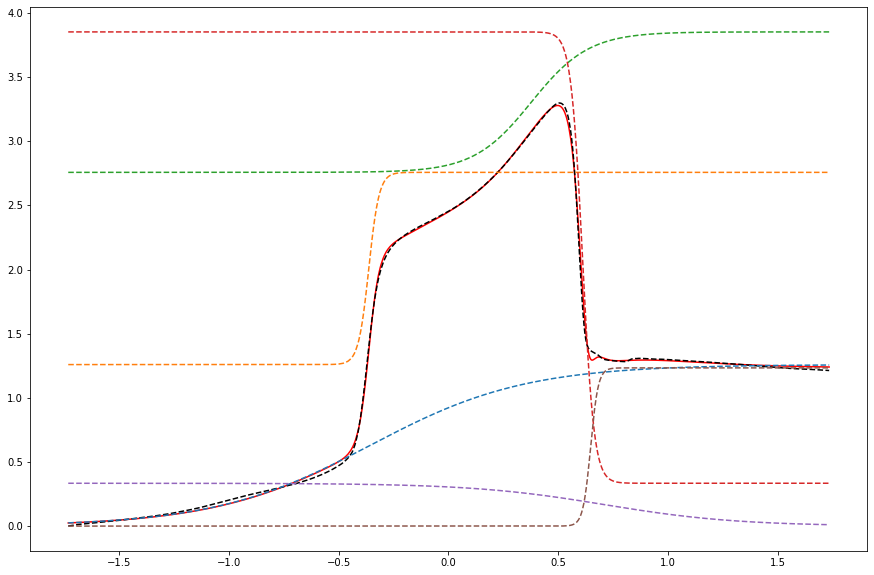

Cost = 0.0004469892127289368
Training model 1...
Epoch 00307: early stopping


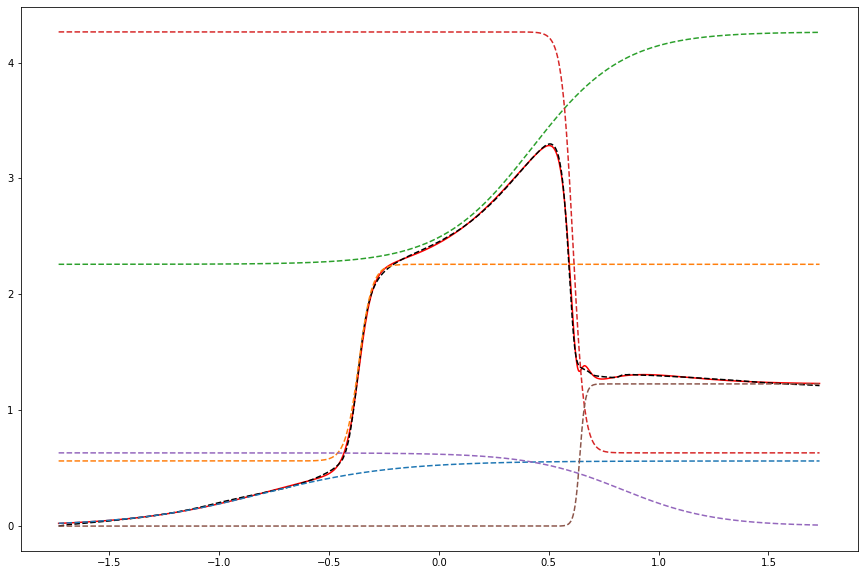

Cost = 0.00018245066752838558
Training model 2...
Epoch 00064: early stopping


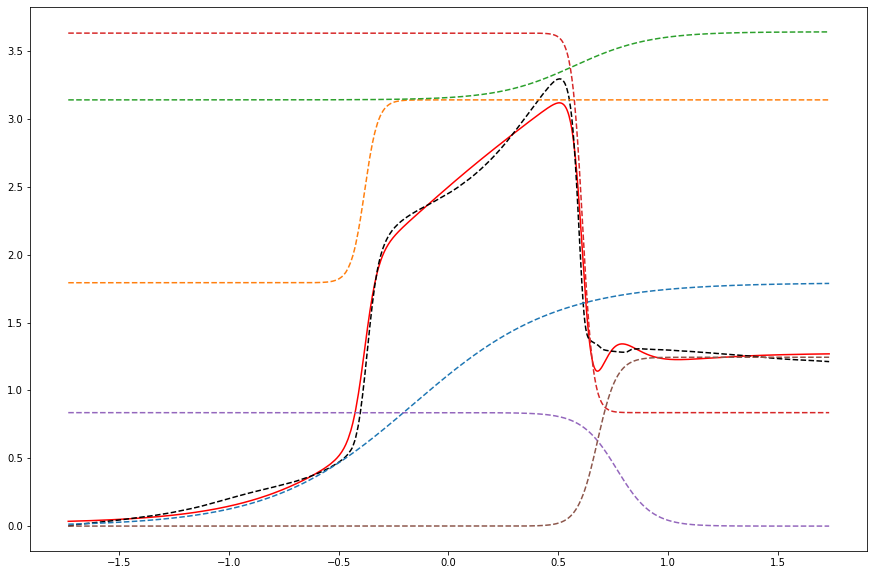

Cost = 0.010291674055609127
Training model 3...


############
Model has failed to converge!                  
Restart optimization                  
Try lowering lr.                  
#############



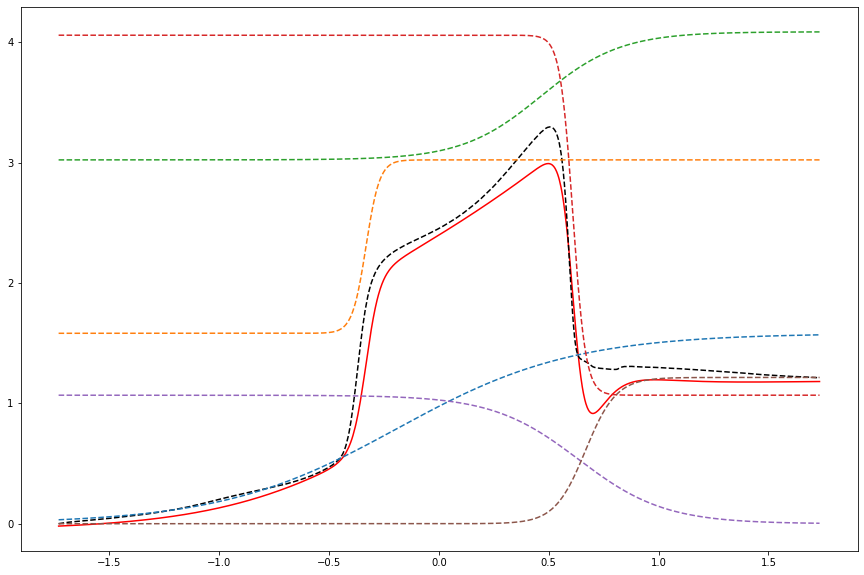

Cost = 0.07591675257547789
Training model 4...


############
Model has failed to converge!                  
Restart optimization                  
Try lowering lr.                  
#############



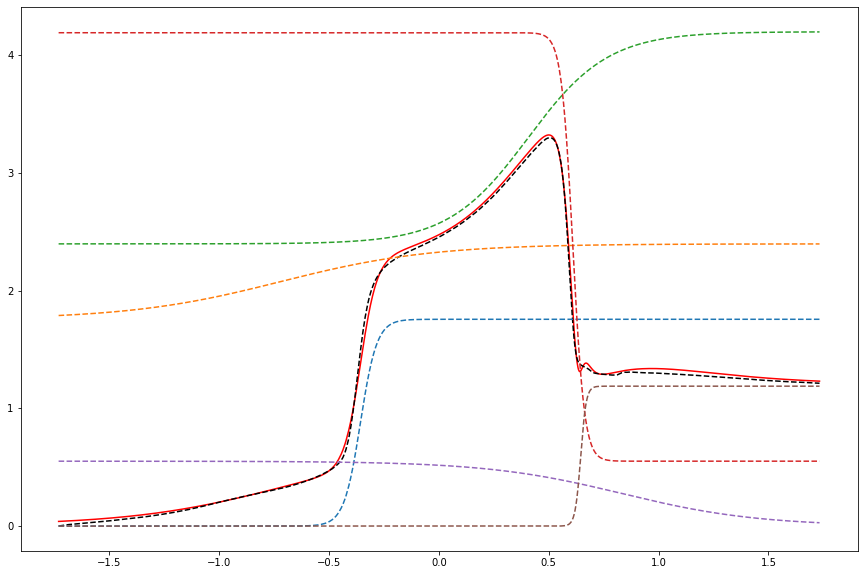

Cost = 0.0016043443004631955


In [4]:
TrainNModels(df,hyper,lr=5e-1,epochs=500,N=5,where=where)

### Run the following cell to let the program know which model you chose.
#### The program threw an index for each model, something like: Training model i...  In the next cell, you just have to put this i there.

In [4]:
index = input("Select a model from the produced above: ")
selectedModel = where.format(index)
finalModel = directory + 'SELECTED_La0.9.hdf5'
!cp {selectedModel} {finalModel}
print(f"\nOk, model {index} will be used in the following section")

Select a model from the produced above: 1

Ok, model 1 will be used in the following section


#### In this case I select Model 1. It has minimum error and curves seem to make sense. 

## The following cell loads the selected model and creates a new hyper array

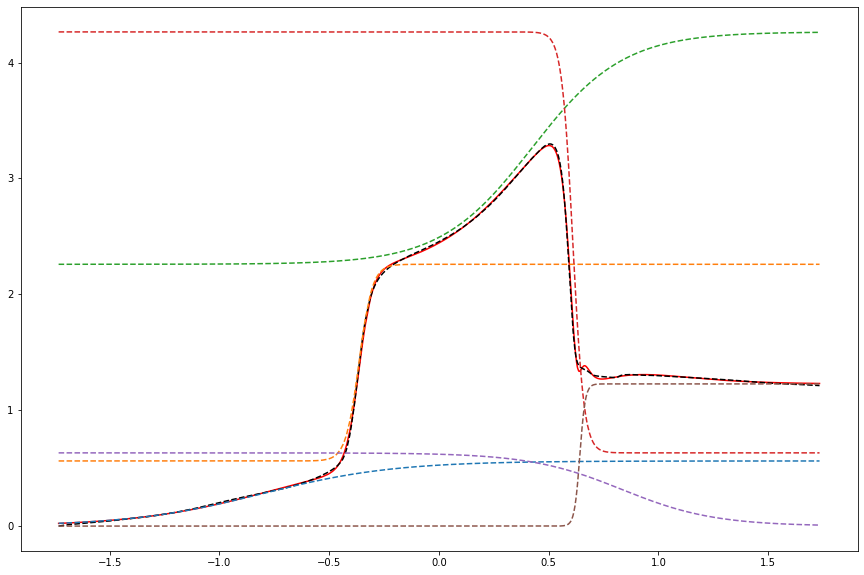

In [5]:
prms = LoadModel(finalModel,hyper)       #Load parameters from chosen model
hyper = BuildHyperFromModel(prms,hyper)  #Update the hyper array with these trained parameters
plot_wr(df,prms,hyper)                   #Plot the model once again

## 3.a. Load other data for same stoichiometry and transfer model.

In [6]:
#Load all data for this stoichiometry
names = !ls data/{stoichiom}*txt
dfs = {}
for name in names:
    df,NormPrms = LoadDF(name,dom=domData)        #Load data
    DFiHyper = TransferHyper(df,hyper)    #Transfer model
    dfs[name] = (df,DFiHyper,NormPrms)
    print(f"{name} successfully loaded.")

data/La0.9Ca0.1NiO310C.txt successfully loaded.
data/La0.9Ca0.1NiO315C.txt successfully loaded.
data/La0.9Ca0.1NiO35C.txt successfully loaded.
data/La0.9Ca0.1NiO38C.txt successfully loaded.


## 3.b. Train each model.

Training for La0.9Ca0.1NiO310C.txt...
Training model 0...
Epoch 00257: early stopping


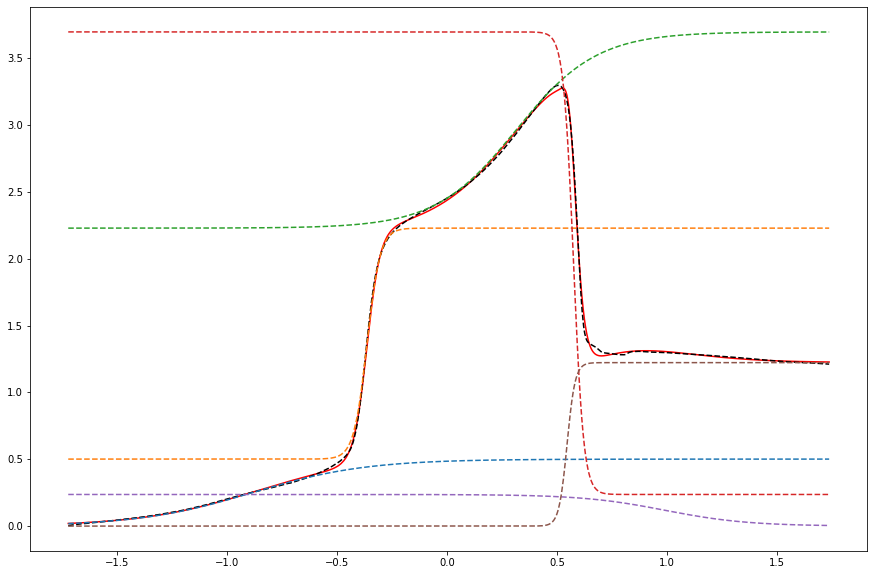

Cost = 0.0003214743136826764
Training model 1...
Epoch 00219: early stopping


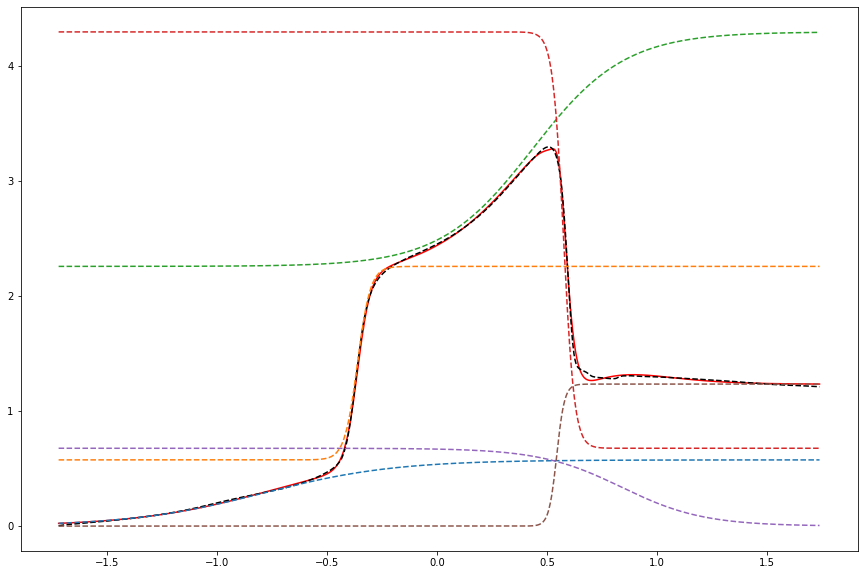

Cost = 0.00033415887360155127
Training for La0.9Ca0.1NiO315C.txt...
Training model 0...
Epoch 00281: early stopping


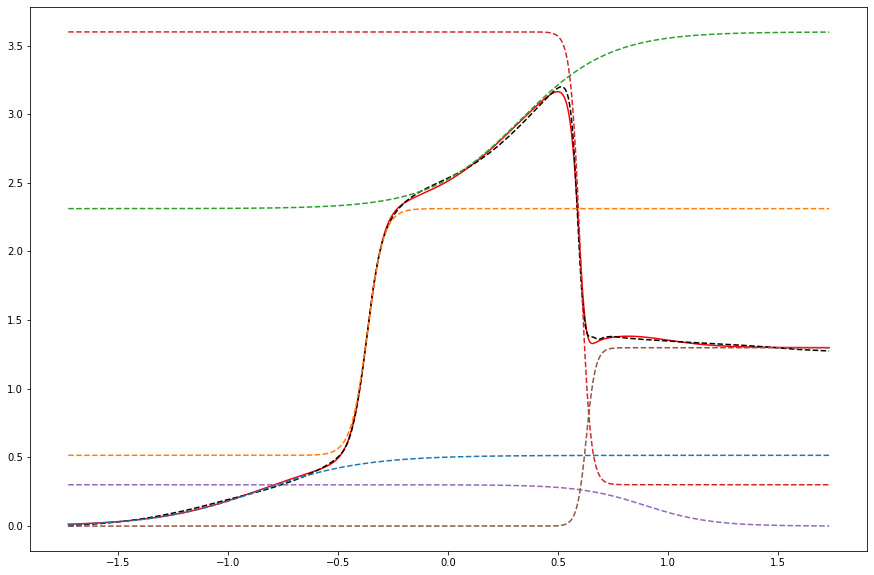

Cost = 0.0005081344928487403
Training model 1...
Epoch 00254: early stopping


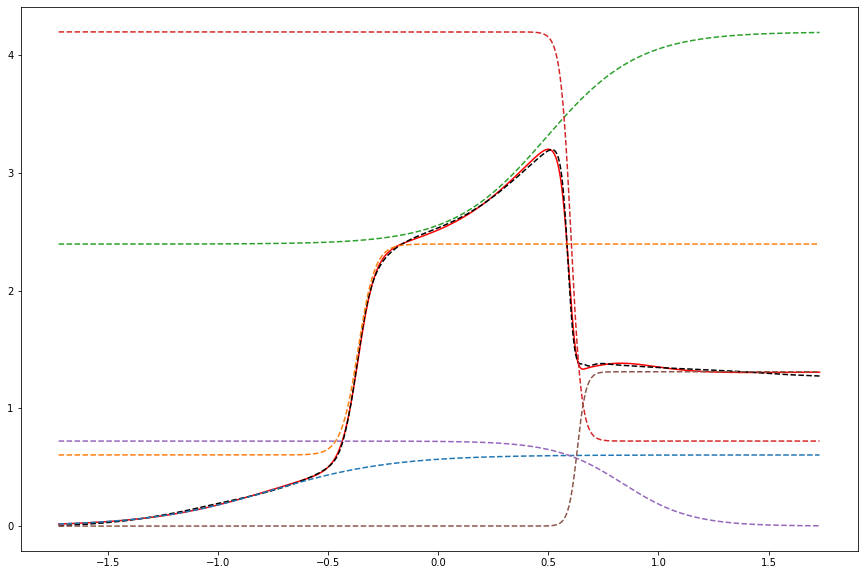

Cost = 0.0003907270717354245
Training for La0.9Ca0.1NiO35C.txt...
Training model 0...
Epoch 00235: early stopping


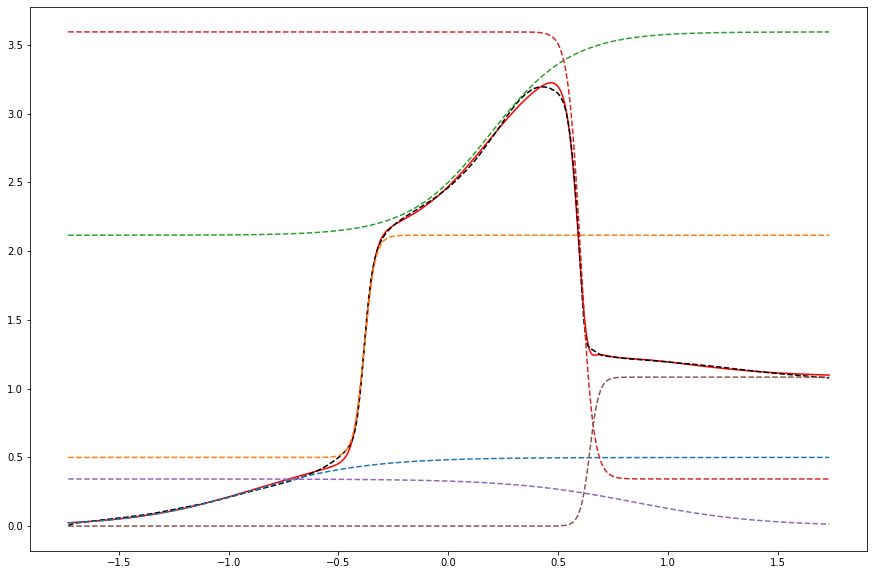

Cost = 0.00028811426655166487
Training model 1...
Epoch 00258: early stopping


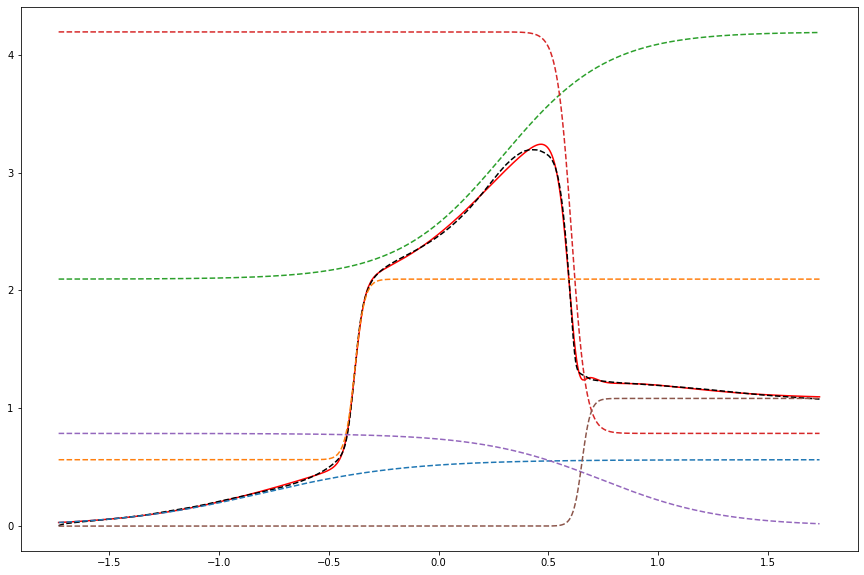

Cost = 0.00036092141869198
Training for La0.9Ca0.1NiO38C.txt...
Training model 0...
Epoch 00236: early stopping


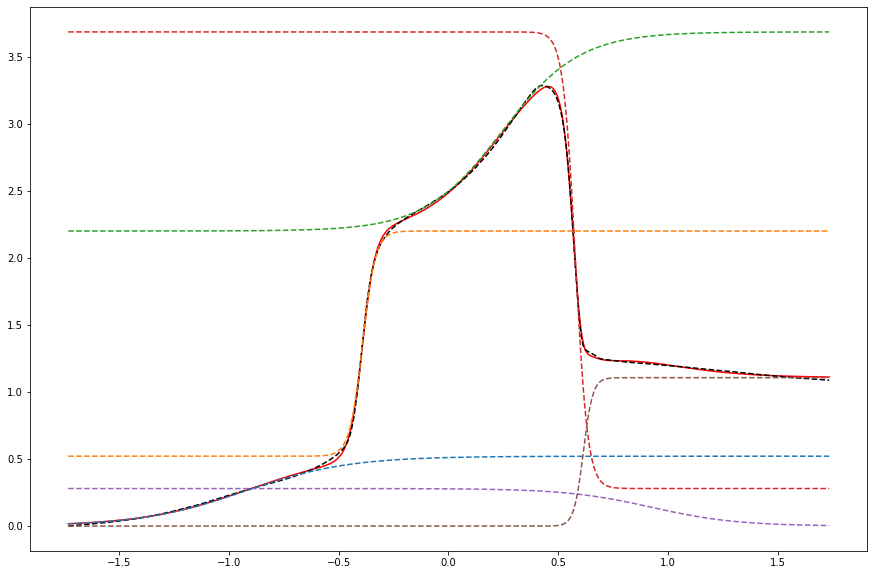

Cost = 0.00019233965905011955
Training model 1...
Epoch 00246: early stopping


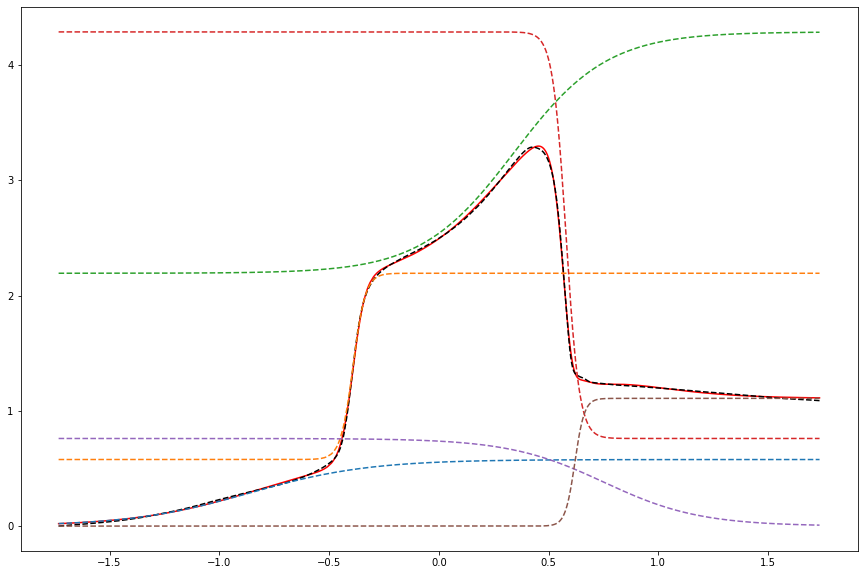

Cost = 0.00016408168583251215


In [10]:
for name in names:
    df,hyper,normPrs = dfs[name]
    name = name.split('/')[-1]
    ############## Tweak hyper to give more freedom, etc
    #Give more freedom to first and second loss events
    hyper[1,3] = 0.3
    hyper[1,4] = 0.2
    #Unfreeze all variables
    hyper[5,:] = 0.0 
    ############# 
    
    where = directory+name+'_W{}.hdf5'
    print(f"Training for {name}...")
    #For each DS train 2 different models with different peak heights
    TrainNModels(df,hyper,lr=5e-2,epochs=500,N=2,where=where,peakRule=lambda x: 0.4 + 0.6*x)

## 4. Now select which models out of the above trained, are to be selected.

### Similar to a few cells above, enter which models you selected.

In [11]:
for name in names:
    name = name.split('/')[-1]
    index = input(f"Select a model for {name}: ")
    selectedModel = where.format(index)
    finalModel = directory + f'SELECTED_{name}.hdf5'
    !cp {selectedModel} {finalModel}

Select a model for La0.9Ca0.1NiO310C.txt: 0
Select a model for La0.9Ca0.1NiO315C.txt: 0
Select a model for La0.9Ca0.1NiO35C.txt: 0
Select a model for La0.9Ca0.1NiO38C.txt: 0


### Now load selected models (just run this cell)

In [12]:
#Load all trained models:
PRMS = {}
for name in names:
    name = name.split('/')[-1]
    if name[:5]==stoichiom:
        file = directory + f'SELECTED_{name}.hdf5'
        print(f"Loading selected model for {name}...")
        PRMS[name] = LoadModel(file,hyper)
print("All models have been successfully loaded")

Loading selected model for La0.9Ca0.1NiO310C.txt...
Loading selected model for La0.9Ca0.1NiO315C.txt...
Loading selected model for La0.9Ca0.1NiO35C.txt...
Loading selected model for La0.9Ca0.1NiO38C.txt...
All models have been successfully loaded


## 5. Extract data and build the linear model

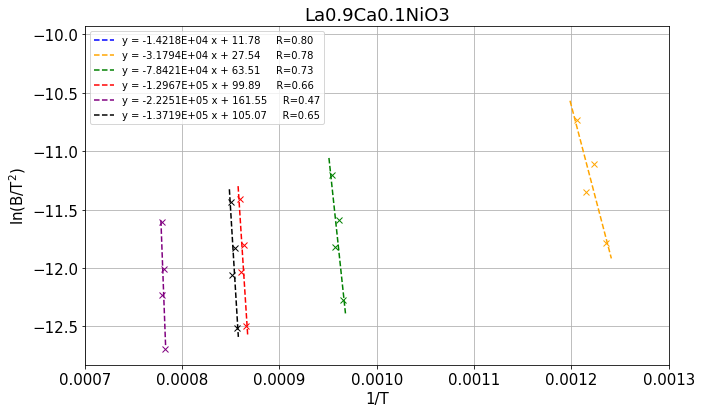

In [29]:
#Build dicts containing extracted and transformed data
steqs = [stoichiom]
X,Y = FeatureDict(PRMS,names,dfs,steqs=steqs,exponent = 2)

#All the dicts have been constructed. Now plot the data and make regression 
PlotLinearModels(X,Y,xlims=[0.0007,0.0013])